# Physical Reservoir Computing Controller
This script communicates with a Raspberry Pi Pico to set the drive current of two LEDs/laser diodes and reads the photocurrents of two photodiodes.

## Connecting to the device

In [57]:
import pyvisa
import numpy as np
import time
import random
import matplotlib.pyplot as plt

In [58]:
# Lists the available ports to connect to
# Find the one which corresponds to the Raspberry Pi Pico plugged in
# On Windows, this may look like COM(X) instead of /dev/ttyACM(X)
rm = pyvisa.ResourceManager('@py')
print(rm)
rm.list_resources()

Resource Manager of Visa Library at py


('ASRL/dev/ttyS31::INSTR',
 'ASRL/dev/ttyS30::INSTR',
 'ASRL/dev/ttyS29::INSTR',
 'ASRL/dev/ttyS28::INSTR',
 'ASRL/dev/ttyS27::INSTR',
 'ASRL/dev/ttyS26::INSTR',
 'ASRL/dev/ttyS25::INSTR',
 'ASRL/dev/ttyS24::INSTR',
 'ASRL/dev/ttyS23::INSTR',
 'ASRL/dev/ttyS22::INSTR',
 'ASRL/dev/ttyS21::INSTR',
 'ASRL/dev/ttyS20::INSTR',
 'ASRL/dev/ttyS19::INSTR',
 'ASRL/dev/ttyS18::INSTR',
 'ASRL/dev/ttyS17::INSTR',
 'ASRL/dev/ttyS16::INSTR',
 'ASRL/dev/ttyS15::INSTR',
 'ASRL/dev/ttyS14::INSTR',
 'ASRL/dev/ttyS13::INSTR',
 'ASRL/dev/ttyS12::INSTR',
 'ASRL/dev/ttyS11::INSTR',
 'ASRL/dev/ttyS10::INSTR',
 'ASRL/dev/ttyS9::INSTR',
 'ASRL/dev/ttyS8::INSTR',
 'ASRL/dev/ttyS7::INSTR',
 'ASRL/dev/ttyS6::INSTR',
 'ASRL/dev/ttyS5::INSTR',
 'ASRL/dev/ttyS4::INSTR',
 'ASRL/dev/ttyS3::INSTR',
 'ASRL/dev/ttyS2::INSTR',
 'ASRL/dev/ttyS1::INSTR',
 'ASRL/dev/ttyS0::INSTR',
 'ASRL/dev/ttyACM1::INSTR')

In [59]:
# Connect to the Pico
inst = rm.open_resource('ASRL/dev/ttyACM1::INSTR')
print(inst)

SerialInstrument at ASRL/dev/ttyACM1::INSTR


## Writing to DAC and Reading from ADC

### DAC
A 12-bit value (between 0 and 4095) is sent to each channel of the DAC. The DAC translates this to a voltage output between 0 and 2.048V. A voltage-to-current converter translates this to current driving each LED according to the following equation:

$I_{LED} = V_{DAC} / R_{V2C} = \frac{2.048\text{V} * value}{2^{12} * R_{V2C}}$

Where $R_{V2C} = 220 \Omega$ so that the max output current is $2.048\text{V} / 220 \Omega = 9.309\text{mA}$.

The MCP6022 opamp used here has trouble sourcing more than about 15mA (found from trial and error) so we limit $R_{V2C}$ to no less than about $150\Omega$ accordingly. There are always some strange nonlinearities of the current to voltage converter as the output approaches 3V; the voltages at the inverting and non-inverting inputs start to differ.

### ADC
A 12-bit value (between 0 and 4095) is read from each channel of the ADC. 0 corresponds to 0V and 4095 corresponds to 3.3V. A current-to-voltage converter (a transimpedance amplifier) translates the photodiode current into a voltage according to the following equation:

$V_{pd} = I_{pd} * R_{trans}$

where $R_{trans} = 51k\Omega$.

Thus $I_{pd} = V_{pd} / R_{trans} = \frac{3.3\text{V} * value}{2^{12} * R_{trans}}$

The max photocurrent readable is $3.3\text{V} / 51k\Omega = 64uA$

In [60]:
# Resistor values
r_v2c = 220
r_trans = 51000

In [79]:
# Write two test values between 0 and 4095 to the two channels of the DAC
values = [123,3700]
#values = [0,0]
inst.write_ascii_values('', values)
#inst.write_ascii_values('', values, converter='f', separator=',') # does the same thing as above
# inst.write('264,3219\n') # does the same thing as above

19

In [83]:
# This read command must follow a write command
# Reads the photocurrents of the two photodiodes
measurements = inst.read_ascii_values()
print(measurements)

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [10]:
# Does the same thing as above but reads the values directly into a numpy array
measurements = inst.read_ascii_values(container=np.array)
print(measurements.dtype)
print(measurements)

float64
[  66. 1232.]


In [8]:
# Test how fast the microcontroller can write and read a fixed number of pairs of values
iterations = 10000

t0 = time.time()
for i in range(iterations):
    values = [0,0]
    values[0] = random.randint(0,4095)
    values[1] = random.randint(0,4095)
    inst.write_ascii_values('', values)
    measurements = inst.read_ascii_values()
    #print(measurements)

t1 = time.time()
total = t1-t0
print(iterations, "iterations took", total, "s.")
print(iterations / total, "iterations/s.")

10000 iterations took 5.53661584854126 s.
1806.1574567494536 iterations/s.


## Test Intensity vs Current Characteristics
Intensity is proportional to photodiode current. The photodiodes are not reverse biased, so dark current should be minimal.

In [92]:
# Find intensities measured at photodiodes when only LED A is driven
drive_current_a = [] # in mA
pd_current_a_from_a = [] # in uA
pd_current_b_from_a = [] # in uA

for i in range(4096):
    # First set 
    values = [0,0]
    values[0] = i
    inst.write_ascii_values('', values)
    measurements = inst.read_ascii_values()

    drive_current_a.append(1000 * 2.048 * i / (4096 * r_v2c))
    pd_current_a_from_a.append(1000000 * 3.3 * measurements[0] / (4096 * r_trans))
    pd_current_b_from_a.append(1000000 * 3.3 * measurements[1] / (4096 * r_trans))  
    #time.sleep(0.1)

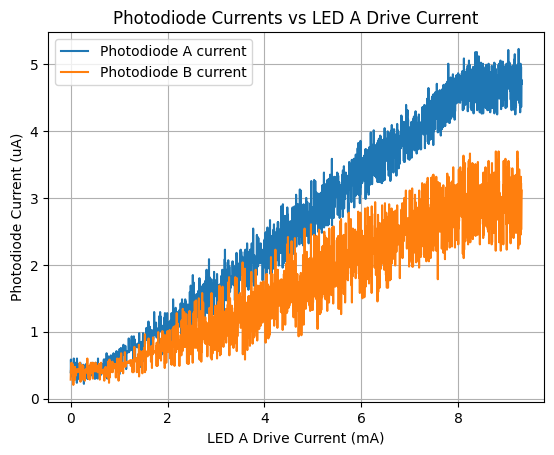

In [93]:
# Plot intensity vs drive current curve for driving LED A
plt.plot(drive_current_a, pd_current_a_from_a, label="Photodiode A current")
plt.plot(drive_current_a, pd_current_b_from_a, label="Photodiode B current")

plt.title("Photodiode Currents vs LED A Drive Current")
plt.xlabel("LED A Drive Current (mA)")
plt.ylabel("Photodiode Current (uA)")
plt.legend()
plt.grid(True)
#plt.savefig("intensity_vs_drive_A.png")
plt.savefig("intensity_vs_drive_A_crossed.png")
plt.show()

In [94]:
# Find intensities measured at photodiodes when only LED B is driven
drive_current_b = [] # in mA
pd_current_a_from_b = [] # in uA
pd_current_b_from_b = [] # in uA

for i in range(4096):
    # First set 
    values = [0,0]
    values[1] = i
    inst.write_ascii_values('', values)
    measurements = inst.read_ascii_values()

    drive_current_b.append(1000 * 2.048 * i / (4096 * r_v2c))
    pd_current_a_from_b.append(1000000 * 3.3 * measurements[0] / (4096 * r_trans))
    pd_current_b_from_b.append(1000000 * 3.3 * measurements[1] / (4096 * r_trans))  
    #time.sleep(0.1)

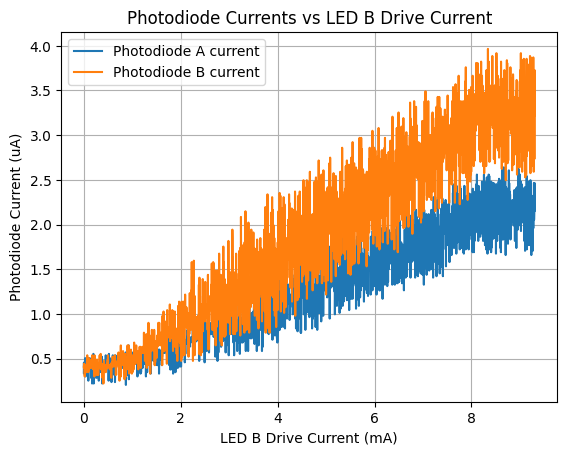

In [95]:
# Plot intensity vs drive current curve for driving LED B
plt.plot(drive_current_b, pd_current_a_from_b, label="Photodiode A current")
plt.plot(drive_current_b, pd_current_b_from_b, label="Photodiode B current")

plt.title("Photodiode Currents vs LED B Drive Current")
plt.xlabel("LED B Drive Current (mA)")
plt.ylabel("Photodiode Current (uA)")
plt.legend()
plt.grid(True)
#plt.savefig("intensity_vs_drive_B.png")
plt.savefig("intensity_vs_drive_B_crossed.png")
plt.show()